In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os.path
from pathlib import Path
import time
import pandas as pd
import pickle as pkl
import librosa as lb
from sklearn import metrics

In [2]:
user = 'tshaw'

In [3]:
def getPredsAndGT(pairsFile, annotFile, pathsRoot, editDur, scoring_collar = 0.1, numThresholds = 1000, \
                   saveFile = None, hop_sec = 0.01):
    insertionAttributions = []
    deletionAttributions = []
    replacementAttributions = []
    
    annotList = list(map(lambda x: x.split(), open(annotFile, 'r').readlines()))
    
    with open(pairsFile, 'r') as f:
        for line in f:
            parts = line.strip().split()
            assert len(parts) == 2
            
            # Find correct annotations
            queryId = os.path.basename(parts[0])[:-4] # [:-4] here to get rid of .wav
            annot = findAnnot(annotList, queryId)
            
            # Find path
            #pathBasename = queryId + '__' + os.path.basename(parts[1])  # This will need to change based on file structure
            pathFile = pathsRoot + '/' + queryId[:-4] + '.pkl' # [:-4] here to get rid of _160
            path = pkl.load(open(pathFile, 'rb'))

            tamperType, theseAttributions = evalQuery(path, annot, scoring_collar, editDur, hop_sec)
            
            # Add new costs and GT to
            if tamperType == "N":
                continue
            elif tamperType == "I":
                insertionAttributions += theseAttributions
            elif tamperType == "D":
                deletionAttributions += theseAttributions
            else:
                replacementAttributions += theseAttributions

    allAttributions = [np.array(insertionAttributions), np.array(deletionAttributions), \
                       np.array(replacementAttributions)]
    
    if saveFile is not None:
        outdir = os.path.dirname(saveFile)
        outdir = Path(outdir)
        outdir.mkdir(parents=True, exist_ok=True)
        pkl.dump(allAttributions, open(saveFile, 'wb'))
        
    return allAttributions

In [4]:
def findAnnot(annotList, queryId):
    for annot in annotList:
        if annot[1] == queryId:
            return annot
    
    print("Error: Annotations not found")
    return None

In [5]:
def evalQuery(hyp, annot, scoring_collar, editDur, hop_sec):
    
    tamperType = annot[0]
    attributions = []
    path = hyp['wp']
    if path.shape[1] == 2:
        pathPreds = hyp['dist']
    else: # For 3 col paths, the third col is the attribution (plane)
        pathPreds = path[:,2]
    
    # set up boundaries list (in seconds, relative to modified query)
    # In form matchingRegionStart, tamperStart, tamperEnd, matchingRegionEndEnd
    # This will depend on tamperType
    if tamperType == "N":
        return tamperType, attributions
    
    elif tamperType == "I":
        insertionStart = float(annot[5])
        insertionEnd = insertionStart + editDur
        
        # I use +/- inf here to signal that the matching region extends to the first and last frames, and no scoring
        # collar is needed
        boundaries = [-float('inf'), insertionStart, insertionEnd, float('inf')]
        query_length = path[0,0]
        startFrame = 0 # startFrame only used for deletions where the path is in the complete wrong place
#         print(query_length * hop_sec)
#         print(boundaries)

    elif tamperType == "D": # For deletions, also flip query and reference
        deletionStart = float(annot[5])
        deletionEnd = deletionStart
        query_length = path[0,0]
        startFrame = 0
        
        # Here, the matching region starts and ends at the boundaries of the query recording
        boundaries = [-float('inf'), deletionStart, deletionEnd, float('inf')]
        
    
    else: # replacement
        replacementStart = float(annot[5])
        replacementEnd = float(annot[6])
        
        # Again, the matching region will extend all the way to the first and last frames
        boundaries = [-float('inf'), replacementStart, replacementEnd, float('inf')]
        query_length = path[0,0]
        startFrame = 0
    
    gt = getAttributionsGT(query_length, boundaries, scoring_collar, hop_sec, startFrame)

    # Impute cost scores
    # Interpolate here to fill in the frames that the path jumps over
    preds = np.interp(np.arange(startFrame, query_length), path[:,0][::-1], pathPreds[::-1])
    
    if path.shape[1] == 3: # for HSTW, the elements that are in both planes default to visible (match)
        preds = np.ceil(preds)

    for i in range(gt.shape[0]):
        if gt[i] >=0:
            attributions.append([gt[i], preds[i]])
         
    return tamperType, attributions

In [6]:
def getAttributionsGT(query_length, boundaries, scoring_collar, hop_sec, startFrame = 0):
    
    gt = np.zeros(query_length - startFrame)
        
    # Get the GT for each frame
    # For now, just represent each frame with a single timestamp (at where the frame begins)
    for frame in range(startFrame, query_length):
        t_query = frame * hop_sec
        if withinCollar(t_query, boundaries, scoring_collar):
            gt[frame-startFrame] = -1
        elif t_query < boundaries[0] or (t_query > boundaries[1] and t_query < boundaries[2]) or t_query > boundaries[3]:
            gt[frame-startFrame] = 1 # Non-matching region
        else:
            gt[frame-startFrame] = 0
            
    return gt

In [7]:
def withinCollar(t_query, boundaries, scoring_collar):
    for t_boundary in boundaries:
        if np.abs(t_query - t_boundary) < scoring_collar:
            return True
    return False

In [8]:
editTimes = [2]
benchmark = 'shortTrain'
systems = ["D1", "D2", "D3", "D4", "NW-80"]
for editTime in editTimes:
    for sys in systems:
        pairsFile = "/mnt/data0/{}/TamperingDetection/cfg_files/{}_{}s.pairs".format(user, benchmark, editTime)
        annotFile = "/mnt/data0/agoutam/TamperingDetection/annots/160kbps_{}sec.gt".format(editTime)
        pathsRoot = "/mnt/data0/{}/TamperingDetection/hyp/{}sec/{}".format(user, editTime,sys)
        saveFile = "/mnt/data0/{}/TamperingDetection/new_eval/{}/{}_{}s.pkl".format(user, sys, benchmark, editTime)
        
        _ = getPredsAndGT(pairsFile, annotFile, pathsRoot, editTime, saveFile = saveFile)

## Find Thresholds on training data

In [9]:
def trainThreshold(sysName, attribFiles, thDictFile):
    if os.path.exists(thDictFile):
        thDict = pkl.load(open(thDictFile, 'rb'))
    else:
        outdir = os.path.dirname(thDictFile)
        outdir = Path(outdir)
        outdir.mkdir(parents=True, exist_ok=True)
        thDict = {}
    
    allAttribs = []
    for attribFile in attribFiles:
        theseAttribs = pkl.load(open(attribFile, 'rb'))
        for thisAttrib in theseAttribs:
            allAttribs.append(thisAttrib)
    
    allAttribs = np.vstack(allAttribs)
    
    TH = findBestThreshold(allAttribs)
    
    thDict[sysName] = TH
    
    pkl.dump(thDict, open(thDictFile, 'wb'))

In [10]:
def findBestThreshold(attributions):
    fps, tps, thresholds = metrics.roc_curve(attributions[:,0], attributions[:,1])
    ROC = np.array([thresholds, fps, 1-tps]).T
    _, TH = findEER(ROC)
    return TH

In [11]:
def findEER(ROC):
    '''
    Calculates Equal Error Rate based on ROC
    
    '''
    minDiff = np.inf
    savedFP = 0
    savedFN = 0
    savedTH = 0

    for rate in ROC:
        TH = rate[0]
        FP = rate[1]
        FN = rate[2]

        if np.abs(FP - FN) < minDiff:
            minDiff = np.abs(FP - FN)
            savedFP = FP
            savedFN = FN
            savedTH = TH
            
    return (savedFP + savedFN) / 2, savedTH

In [12]:
editTimes = [2]
benchmark = 'shortTrain'
systems = ["D1", "D2", "D3", "D4", "NW-80"]
thDictFile = "/mnt/data0/{}/TamperingDetection/new_eval/thresholds.pkl".format(user)
for sys in systems:
    attribFiles = []
    for editTime in editTimes:
        attribFiles.append("/mnt/data0/{}/TamperingDetection/new_eval/{}/{}_{}s.pkl".format(user, sys, benchmark, editTime))
    trainThreshold(sys, attribFiles, thDictFile)

In [13]:
thDict = pkl.load(open(thDictFile, 'rb'))

In [14]:
thDict

{'D1': 33.32400486056446,
 'D2': 30.355922373558787,
 'D3': 34.15973282803315,
 'D4': 37.738482925370064,
 'NW-80': 63.40327323969339}

### Figures

In [15]:
def plotAttribution(timesToPlot, systemsToPlot, benchmark, thDictFile, displayNames, saveFile = None):
    fig, axs = plt.subplots(2, len(timesToPlot), figsize = (7, 15))
    axs = axs.reshape(2, len(timesToPlot)) # Comment this out for more than 1 edit time
    thDict = pkl.load(open(thDictFile, 'rb'))

    for i, plotTime in enumerate(timesToPlot):
        x = np.arange(len(systemsToPlot))
        numBars = 3
        width = 0.75 / numBars
        axs[0,i].grid(zorder=0)
        axs[1,i].grid(zorder=0)

        insertions = []
        deletions = []
        replacements = []
        for j, plotSys in enumerate(systemsToPlot):
            if plotSys in thDict.keys():
                th = thDict[plotSys]
            else:
                th = None
            attribFile = "/mnt/data0/{}/TamperingDetection/new_eval/{}/{}_{}s.pkl".format(user, plotSys, benchmark, plotTime)
            
            attribs = pkl.load(open(attribFile, 'rb'))
            insertions.append(calcFPFN(attribs[0], th))
            deletions.append(calcFPFN(attribs[1], th))
            replacements.append(calcFPFN(attribs[2], th))
        
        
        insertions = np.array(insertions)
        deletions = np.array(deletions)
        replacements = np.array(replacements)

        axs[0,i].bar(x - width, insertions[:,1] * 100, width, zorder = 3)
        axs[0,i].bar(x, replacements[:,1] * 100, width, zorder = 3)
        axs[0,i].bar(x + width, deletions[:,1] * 100, width, zorder = 3)
        
        axs[1,i].bar(x - width/2, insertions[:,0] * 100, width, zorder = 3)
        axs[1,i].bar(x+width/2, replacements[:,0] * 100, width, zorder = 3)
        
        
        axs[0,i].set_xlabel("System")
        axs[0,i].set_xticks(x)
        axs[0,i].set_xticklabels(sysNames, rotation = 90)
        #axs[0,i].set_ylim(0,20)
        axs[0,i].set_title("L = " + str(plotTime))
        
        axs[1,i].set_xlabel("System")
        axs[1,i].set_xticks(x)
        axs[1,i].set_xticklabels(sysNames, rotation = 90)
        #axs[1,i].set_ylim(0,20)
        axs[1,i].set_title("L = " + str(plotTime))

    plt.figlegend(["Insertions", "Replacements", "Deletions"])
    fig.suptitle("Attribution Error Rates", fontsize = 'x-large')
    axs[0,0].set_ylabel("Matching Region Error Rate (%)", fontsize = "large")
    axs[1,0].set_ylabel("Non-Matching Region Error Rate (%)", fontsize = "large")

    fig.tight_layout()
    
    if saveFile is not None:
        plt.savefig(saveFile)

In [16]:
def calcFPFN(attribs, threshold = None):
    '''
    Calculate number of false positives and false negatives
    '''
    gt = attribs[:,0]
    if threshold is not None:
        # If cost is lower than threshold, then we consider sample in
        # non tampered region (nontampered = 0, tampered = 1)
        preds = (attribs[:,1] >= threshold).astype(int)
    else:
        preds = attribs[:,1]

    diffVec = (preds - gt)

    FPCount = np.sum((diffVec == -1).astype(int))
    FNCount = np.sum((diffVec == 1).astype(int))
    
    TrueNegCount = np.sum(gt == 1) # Note: Positive means match
    TruePosCount = np.sum(gt == 0)
    
    if TrueNegCount == 0: #Prevent a divide by zero error for deletions
        return [0, FNCount / TruePosCount]
    return [FPCount / TrueNegCount, FNCount / TruePosCount]

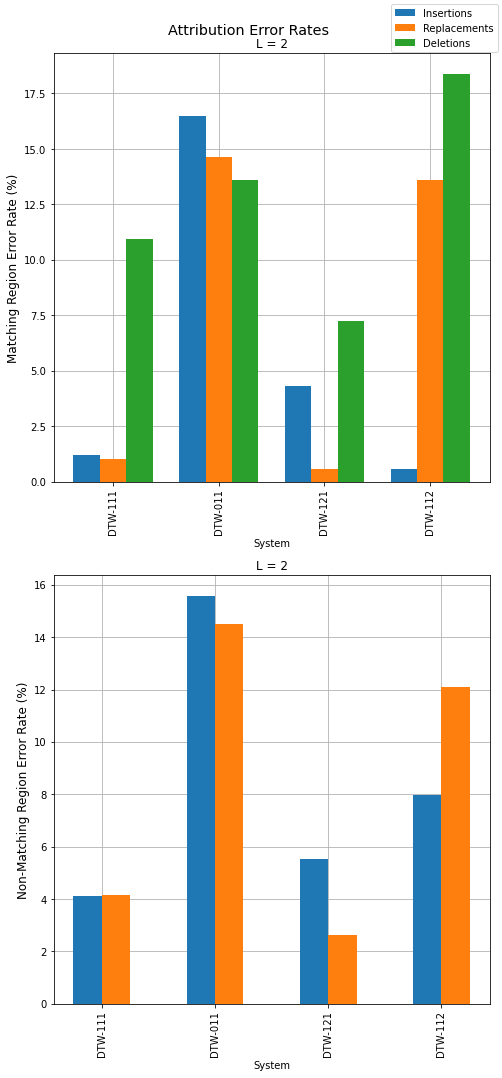

In [21]:
timesToPlot = [2]
systemsToPlot = ["D1", "D2", "D3", "D4"]#["D1", "D2", "D3", "D4", "NW-80", "HSTW"]
sysNames = ["DTW-111", "DTW-011", "DTW-121", "DTW-112"]#["DTW-111", "DTW-011","DTW-121", "DTW-112", "NW-80", "HSTW"]
benchmark = "shortTrain"
thDictFile = "/mnt/data0/{}/TamperingDetection/new_eval/thresholds.pkl".format(user)
saveFile = "speechAttribFig.png"

plotAttribution(timesToPlot, systemsToPlot, benchmark, thDictFile, sysNames, saveFile)

In [18]:
plotSys = "NW-80"
plotTime = 2
insertions = []
deletions = []
replacements = []
if plotSys in thDict.keys():
    th = thDict[plotSys]
    print(th)
else:
    th = None
attribFile = "/mnt/data0/{}/TamperingDetection/new_eval/{}/{}_{}s.pkl".format(user, plotSys, benchmark, plotTime)

attribs = pkl.load(open(attribFile, 'rb'))
insertions.append(calcFPFN(attribs[0], th))
deletions.append(calcFPFN(attribs[1], th))
replacements.append(calcFPFN(attribs[2], th))

63.40327323969339


In [19]:
path = pkl.load(open("/mnt/data0/tshaw/TamperingDetection/hyp/2sec/NW-80/12_30_17_r9.pkl", 'rb'))

In [20]:
path['wp']

array([[ 998, 2613],
       [ 997, 2612],
       [ 996, 2611],
       ...,
       [   2, 2195],
       [   1, 2194],
       [   0, 2194]])

In [ ]:
ROCfile = "/mnt/data0/{}/TamperingDetection/eval/D3/train_2s.pkl".format(user)
ROCs = pkl.load(open(ROCfile, 'rb'))

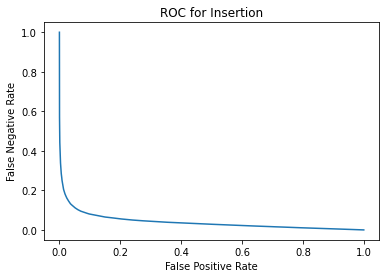

In [27]:
ROC = ROCs[0]
plt.plot(ROC[:,1], ROC[:,2])
plt.xlabel("False Positive Rate");
plt.ylabel("False Negative Rate");
plt.title("ROC for Insertion");

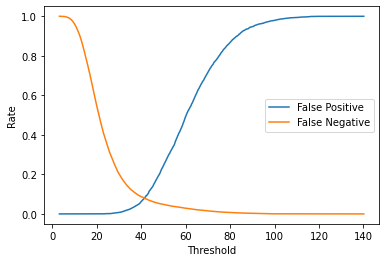

In [69]:
plt.plot(ROC[:,0], ROC[:,1]);
plt.plot(ROC[:,0], ROC[:,2]);
plt.xlabel("Threshold");
plt.ylabel("Rate")
plt.legend(["False Positive", "False Negative"]);

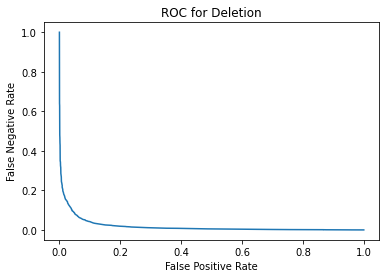

In [70]:
ROC = ROCs[1]
plt.plot(ROC[:,1], ROC[:,2])
plt.xlabel("False Positive Rate");
plt.ylabel("False Negative Rate");
plt.title("ROC for Deletion");

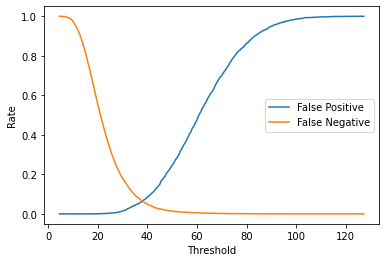

In [71]:
plt.plot(ROC[:,0], ROC[:,1]);
plt.plot(ROC[:,0], ROC[:,2]);
plt.xlabel("Threshold");
plt.ylabel("Rate")
plt.legend(["False Positive", "False Negative"]);

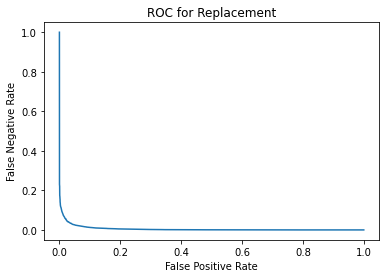

In [72]:
ROC = ROCs[2]
plt.plot(ROC[:,1], ROC[:,2])
plt.xlabel("False Positive Rate");
plt.ylabel("False Negative Rate");
plt.title("ROC for Replacement");

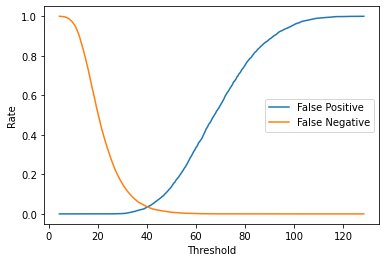

In [73]:
plt.plot(ROC[:,0], ROC[:,1]);
plt.plot(ROC[:,0], ROC[:,2]);
plt.xlabel("Threshold");
plt.ylabel("Rate")
plt.legend(["False Positive", "False Negative"]);

## Finding NW Gamma

In [74]:
editTime = 2

In [7]:
expGammas = [0.1, 1, 10, 100, 1000]
# for gamma in expGammas:
#     pairsFile = "/mnt/data0/agoutam/TamperingDetection/cfg_files/train_2s.pairs"
#     annotFile = "/mnt/data0/agoutam/TamperingDetection/annots/160kbps_2sec.gt"
#     pathsRoot = "/mnt/data0/tshaw/TamperingDetection/hyp/NW/train_2s/gamma=%s" % str(gamma)
#     saveFile = "/mnt/data0/tshaw/TamperingDetection/eval/NW/gamma=%s/train_2s.pkl" % str(gamma)
        
#     _ = evalAllQueries(pairsFile, annotFile, pathsRoot, editTime, saveFile = saveFile)

In [8]:
EERs = []
for gamma in [0.1, 1, 10, 100, 1000]:
    ROCFile = "/mnt/data0/tshaw/TamperingDetection/eval/NW/gamma=%s/train_2s.pkl" % str(gamma)
    ROC = pkl.load(open(ROCFile, "rb"))[3]
    EERs.append(findEER(ROC))

In [9]:
EERs

[0.4786605427714567,
 0.4834524619095293,
 0.4818794445850787,
 0.051320447379096495,
 0.11395771966801556]

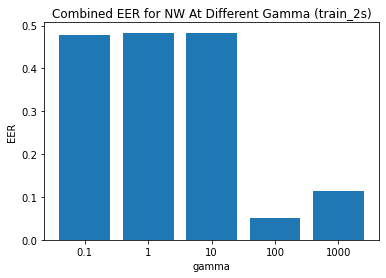

In [10]:
plt.bar(np.arange(5),EERs);
plt.xticks(np.arange(5), expGammas);
plt.xlabel("gamma")
plt.title("Combined EER for NW At Different Gamma (train_2s)");
# plt.ylim(0,1);
plt.ylabel("EER");

In [15]:
expGammas2 = [50, 100, 200, 500]
# for gamma in expGammas2:
#     pairsFile = "/mnt/data0/agoutam/TamperingDetection/cfg_files/train_2s.pairs"
#     annotFile = "/mnt/data0/agoutam/TamperingDetection/annots/160kbps_2sec.gt"
#     pathsRoot = "/mnt/data0/tshaw/TamperingDetection/hyp/NW/train_2s/gamma=%s" % str(gamma)
#     saveFile = "/mnt/data0/tshaw/TamperingDetection/eval/NW/gamma=%s/train_2s.pkl" % str(gamma)
        
#     _ = evalAllQueries(pairsFile, annotFile, pathsRoot, editTime, saveFile = saveFile)

In [16]:
EERs = []
for gamma in expGammas2:
    ROCFile = "/mnt/data0/tshaw/TamperingDetection/eval/NW/gamma=%s/train_2s.pkl" % str(gamma)
    ROC = pkl.load(open(ROCFile, "rb"))[3]
    EERs.append(findEER(ROC))

In [17]:
EERs

[0.054543195954302265,
 0.051320447379096495,
 0.11081710593351798,
 0.1139270633076631]

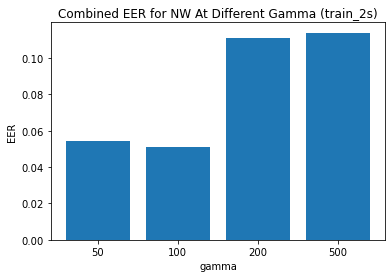

In [20]:
plt.bar(np.arange(len(EERs)),EERs);
plt.xticks(np.arange(len(EERs)), expGammas2);
plt.xlabel("gamma")
plt.title("Combined EER for NW At Different Gamma (train_2s)");
# plt.ylim(0,1);
plt.ylabel("EER");

In [42]:
linGammas = [50, 60, 70, 80, 90, 100]
# for gamma in linGammas:
#     pairsFile = "/mnt/data0/agoutam/TamperingDetection/cfg_files/train_2s.pairs"
#     annotFile = "/mnt/data0/agoutam/TamperingDetection/annots/160kbps_2sec.gt"
#     pathsRoot = "/mnt/data0/tshaw/TamperingDetection/hyp/NW/train_2s/gamma=%s" % str(gamma)
#     saveFile = "/mnt/data0/tshaw/TamperingDetection/eval/NW/gamma=%s/train_2s.pkl" % str(gamma)
        
#     _ = evalAllQueries(pairsFile, annotFile, pathsRoot, editTime, saveFile = saveFile)

In [43]:
EERs = []
for gamma in linGammas:
    ROCFile = "/mnt/data0/tshaw/TamperingDetection/eval/NW/gamma=%s/train_2s.pkl" % str(gamma)
    ROC = pkl.load(open(ROCFile, "rb"))[3]
    EERs.append(findEER(ROC))

In [44]:
EERs

[0.054543195954302265,
 0.05206043397068241,
 0.049069678056523,
 0.04846582882389572,
 0.04946689419920694,
 0.051320447379096495]

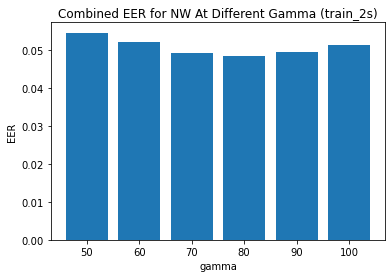

In [45]:
plt.bar(np.arange(len(EERs)),EERs);
plt.xticks(np.arange(len(EERs)), linGammas);
plt.xlabel("gamma")
plt.title("Combined EER for NW At Different Gamma (train_2s)");
# plt.ylim(0,1);
plt.ylabel("EER");